In [12]:
from __future__ import division, print_function
from keras import backend as K
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

In [13]:
# In [2]:
DATA_DIR = ""
IMAGE_DIR = os.path.join(DATA_DIR, "images")

BATCH_SIZE = 32
NUM_EPOCHS = 10

In [14]:
os.getcwd()

'/home/ubuntu/siamese'

In [15]:
image_groups = {}
for image_name in os.listdir(IMAGE_DIR):
    base_name = image_name[0:-4]
    group_name = base_name[0:4]
    if group_name in image_groups:
        image_groups[group_name].append(image_name)
    else:
        image_groups[group_name] = [image_name]
num_sims = 0
image_triples = []
group_list = sorted(list(image_groups.keys()))
for i, g in enumerate(group_list):
    if num_sims % 100 == 0:
        print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                .format(num_sims, num_sims, 2*num_sims))
    images_in_group = image_groups[g]
    sim_pairs_it = itertools.combinations(images_in_group, 2)
    # for each similar pair, generate a corresponding different pair
    for ref_image, sim_image in sim_pairs_it:
        image_triples.append((ref_image, sim_image, 1))
        num_sims += 1
        while True:
            j = np.random.randint(low=0, high=len(group_list), size=1)[0]
            if j != i:
                break
        dif_image_candidates = image_groups[group_list[j]]
        k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
        dif_image = dif_image_candidates[k]
        image_triples.append((ref_image, dif_image, 0))
print("Generated {:d} pos + {:d} neg = {:d} total image triples"
        .format(num_sims, num_sims, 2*num_sims))

Generated 0 pos + 0 neg = 0 total image triples
Generated 900 pos + 900 neg = 1800 total image triples
Generated 1656 pos + 1656 neg = 3312 total image triples


In [4]:
image_triples

[('010006.jpg', '010003.jpg', 1),
 ('010006.jpg', '400009.jpg', 0),
 ('010006.jpg', '010004.jpg', 1),
 ('010006.jpg', '390001.jpg', 0),
 ('010006.jpg', '010007.jpg', 1),
 ('010006.jpg', '150007.jpg', 0),
 ('010006.jpg', '010001.jpg', 1),
 ('010006.jpg', '120003.jpg', 0),
 ('010006.jpg', '010005.jpg', 1),
 ('010006.jpg', '170001.jpg', 0),
 ('010006.jpg', '010008.jpg', 1),
 ('010006.jpg', '200008.jpg', 0),
 ('010006.jpg', '010009.jpg', 1),
 ('010006.jpg', '430009.jpg', 0),
 ('010006.jpg', '010002.jpg', 1),
 ('010006.jpg', '390007.jpg', 0),
 ('010003.jpg', '010004.jpg', 1),
 ('010003.jpg', '220009.jpg', 0),
 ('010003.jpg', '010007.jpg', 1),
 ('010003.jpg', '130008.jpg', 0),
 ('010003.jpg', '010001.jpg', 1),
 ('010003.jpg', '050004.jpg', 0),
 ('010003.jpg', '010005.jpg', 1),
 ('010003.jpg', '320005.jpg', 0),
 ('010003.jpg', '010008.jpg', 1),
 ('010003.jpg', '160001.jpg', 0),
 ('010003.jpg', '010009.jpg', 1),
 ('010003.jpg', '370005.jpg', 0),
 ('010003.jpg', '010002.jpg', 1),
 ('010003.jpg'

In [16]:
# In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if group_name in image_groups:
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples   

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "r")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def train_test_split(triples, splits):
    assert sum(splits) == 1.0
    split_pts = np.cumsum(np.array([0.] + splits))
    indices = np.random.permutation(np.arange(len(triples)))
    shuffled_triples = [triples[i] for i in indices]
    data_splits = []
    for sid in range(len(splits)):
        start = int(split_pts[sid] * len(triples))
        end = int(split_pts[sid + 1] * len(triples))
        data_splits.append(shuffled_triples[start:end])
    return data_splits

def batch_to_vectors(batch, vec_size, vec_dict):
    X1 = np.zeros((len(batch), vec_size))
    X2 = np.zeros((len(batch), vec_size))
    Y = np.zeros((len(batch), 2))
    for tid in range(len(batch)):
        X1[tid] = vec_dict[batch[tid][0]]
        X2[tid] = vec_dict[batch[tid][1]]
        Y[tid] = [1, 0] if batch[tid][2] == 0 else [0, 1]
    return ([X1, X2], Y)
    
def data_generator(triples, vec_size, vec_dict, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            yield batch_to_vectors(batch, vec_size, vec_dict)

def evaluate_model(model_file, test_gen):
    model_name = os.path.basename(model_file)
    model = load_model(model_file)
    print("=== Evaluating model: {:s} ===".format(model_name))
    ytrue, ypred = [], []
    num_test_steps = len(test_triples) // BATCH_SIZE
    for i in range(num_test_steps):
        (X1, X2), Y = test_gen.__next__()
        Y_ = model.predict([X1, X2])
        ytrue.extend(np.argmax(Y, axis=1).tolist())
        ypred.extend(np.argmax(Y_, axis=1).tolist())
    accuracy = accuracy_score(ytrue, ypred)
    print("\nAccuracy: {:.3f}".format(accuracy))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytrue, ypred))
    print("\nClassification Report")
    print(classification_report(ytrue, ypred))
    return accuracy

def get_model_file(data_dir, vector_name, merge_mode, borf):
    return os.path.join(data_dir, "models", "A_A_{:s}-{:s}-{:s}_10_adam.h5"
                        .format(vector_name, merge_mode, borf))

In [17]:
# Declare and Extract Common Data
# In [4]:
VECTORIZERS = ["InceptionV3", "ResNet"]
# VECTORIZERS = ["VGG16", "VGG19", "InceptionV3", "ResNet"]
MERGE_MODES = ["Concat", "Dot", "AbsDiff", "Euclidean"]
scores = np.zeros((len(VECTORIZERS), len(MERGE_MODES)))
# In [5]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 900 pos + 900 neg = 1800 total image triples
Generated 1656 pos + 1656 neg = 3312 total image triples


In [18]:
# In [6]:
train_triples, val_triples, test_triples = train_test_split(image_triples, 
                                                            splits=[0.7, 0.1, 0.2])
print(len(train_triples), len(val_triples), len(test_triples))

# InceptionV3 Vectors
# In [7]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-inception-vectors.tsv")
# In [8]:
vec_dict = load_vectors(VECTOR_FILE)

2318 331 663


Epoch 1/10
72/72 [==============================] - 1s 21ms/step - loss: 0.8253 - acc: 0.5030 - val_loss: 0.6935 - val_acc: 0.5219
Epoch 2/10
72/72 [==============================] - 1s 12ms/step - loss: 0.7001 - acc: 0.4935 - val_loss: 0.6924 - val_acc: 0.5156
Epoch 3/10
72/72 [==============================] - 1s 12ms/step - loss: 0.6954 - acc: 0.4974 - val_loss: 0.6931 - val_acc: 0.5031
Epoch 4/10
72/72 [==============================] - 1s 11ms/step - loss: 0.6937 - acc: 0.5217 - val_loss: 0.6923 - val_acc: 0.4625
Epoch 5/10
72/72 [==============================] - 1s 12ms/step - loss: 0.6862 - acc: 0.5365 - val_loss: 0.6895 - val_acc: 0.5281
Epoch 6/10
72/72 [==============================] - 1s 11ms/step - loss: 0.6649 - acc: 0.5842 - val_loss: 0.6374 - val_acc: 0.6406
Epoch 7/10
72/72 [==============================] - 1s 12ms/step - loss: 0.6099 - acc: 0.6593 - val_loss: 0.5607 - val_acc: 0.7406
Epoch 8/10
72/72 [==============================] - 1s 12ms/step - loss: 0.5195 - a

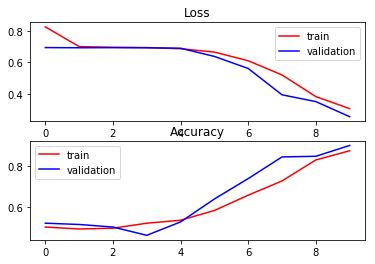

=== Evaluating model: A_A_inceptionv3-cat-final_10_adam.h5 ===

Accuracy: 0.906

Confusion Matrix
[[287  31]
 [ 29 293]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.90      0.91       318
          1       0.90      0.91      0.91       322

avg / total       0.91      0.91      0.91       640

=== Evaluating model: A_A_inceptionv3-cat-best_10_adam.h5 ===

Accuracy: 0.912

Confusion Matrix
[[287  28]
 [ 28 297]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.91      0.91       315
          1       0.91      0.91      0.91       325

avg / total       0.91      0.91      0.91       640



In [19]:
# Input: Concatenate Vectors
# In [9]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [10]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Concatenate(axis=-1)([input_1, input_2]) ###

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

# In [11]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [13]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "cat", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [14]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [15]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "cat", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 0] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

# Input: Elementwise Cosine Distance
# In [16]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

(10,) (10,)
(10,)
Epoch 1/10
72/72 [==============================] - 1s 18ms/step - loss: 0.5177 - acc: 0.7339 - val_loss: 0.2513 - val_acc: 0.9062
Epoch 2/10
72/72 [==============================] - 1s 7ms/step - loss: 0.1736 - acc: 0.9366 - val_loss: 0.0516 - val_acc: 0.9906
Epoch 3/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0899 - acc: 0.9670 - val_loss: 0.0345 - val_acc: 0.9969
Epoch 4/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0692 - acc: 0.9783 - val_loss: 0.0355 - val_acc: 0.9844
Epoch 5/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0342 - acc: 0.9900 - val_loss: 0.0216 - val_acc: 0.9969
Epoch 6/10
72/72 [==============================] - 1s 7ms/step - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 7/10
72/72 [==============================] - 1s 7ms/step - loss: 0.0452 - acc: 0.9835 - val_loss: 0.0264 - val_acc: 0.9938
Epoch 8/10
72/72 [==============================] - 1s 7ms/step - loss:

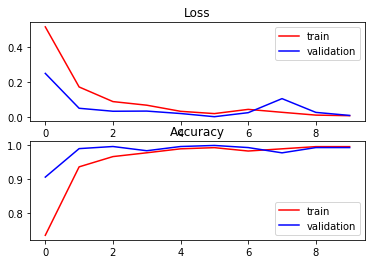

=== Evaluating model: A_A_inceptionv3-dot-final_10_adam.h5 ===

Accuracy: 0.998

Confusion Matrix
[[313   1]
 [  0 326]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       314
          1       1.00      1.00      1.00       326

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_inceptionv3-dot-best_10_adam.h5 ===

Accuracy: 0.998

Confusion Matrix
[[315   1]
 [  0 324]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       316
          1       1.00      1.00      1.00       324

avg / total       1.00      1.00      1.00       640



In [20]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

# In [17]:
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = cosine_distance(vecs)
print(s.shape)
# (10,) (10,)
# (10,)
# In [18]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([input_1, input_2]) ###

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [19]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [20]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [21]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "dot", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [22]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [23]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "dot", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 1] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: inceptionv3-dot-final.h5 ===


(10,) (10,)
(10,)
Epoch 1/10
72/72 [==============================] - 1s 20ms/step - loss: 0.4947 - acc: 0.7409 - val_loss: 0.1596 - val_acc: 0.9719
Epoch 2/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0954 - acc: 0.9779 - val_loss: 0.0249 - val_acc: 0.9969
Epoch 3/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0348 - acc: 0.9891 - val_loss: 0.0545 - val_acc: 0.9906
Epoch 4/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0221 - acc: 0.9944 - val_loss: 0.0201 - val_acc: 1.0000
Epoch 5/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0228 - acc: 0.9944 - val_loss: 0.0597 - val_acc: 0.9812
Epoch 6/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0189 - acc: 0.9939 - val_loss: 0.0145 - val_acc: 0.9938
Epoch 7/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 0.9938
Epoch 8/10
72/72 [==============================] - 1s 8ms/step - loss:

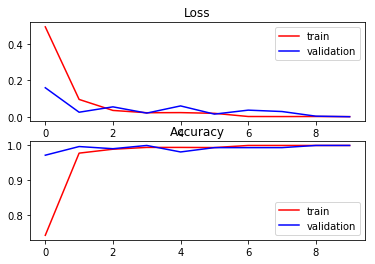

=== Evaluating model: A_A_inceptionv3-l1-final_10_adam.h5 ===

Accuracy: 1.000

Confusion Matrix
[[319   0]
 [  0 321]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       319
          1       1.00      1.00      1.00       321

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_inceptionv3-l1-best_10_adam.h5 ===

Accuracy: 1.000

Confusion Matrix
[[316   0]
 [  0 324]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       316
          1       1.00      1.00      1.00       324

avg / total       1.00      1.00      1.00       640



In [21]:
# In [24]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [25]:
def absdiff(vecs):
    x, y = vecs
    return K.abs(K.sum(K.stack([x, -y], axis=1), axis=1))

'''
abs 元素级的绝对值操作。
'''

def absdiff_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = absdiff(vecs)
print(s.shape)

# In [26]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(absdiff, output_shape=absdiff_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [27]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [28]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [29]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "l1", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [30]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [31]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "l1", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 2] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: inceptionv3-l1-final.h5 ===

(10,) (10,)
(10,)
Epoch 1/10
72/72 [==============================] - 2s 22ms/step - loss: 0.6131 - acc: 0.6415 - val_loss: 0.4205 - val_acc: 0.8156
Epoch 2/10
72/72 [==============================] - 1s 8ms/step - loss: 0.2644 - acc: 0.9019 - val_loss: 0.1665 - val_acc: 0.9437
Epoch 3/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0931 - acc: 0.9692 - val_loss: 0.1948 - val_acc: 0.9406
Epoch 4/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0690 - acc: 0.9796 - val_loss: 0.0746 - val_acc: 0.9812
Epoch 5/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0451 - acc: 0.9865 - val_loss: 0.0617 - val_acc: 0.9844
Epoch 6/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0994 - acc: 0.9692 - val_loss: 0.0468 - val_acc: 0.9875
Epoch 7/10
72/72 [==============================] - 1s 8ms/step - loss: 0.0280 - acc: 0.9905 - val_loss: 0.0461 - val_acc: 0.9875
Epoch 8/10
72/72 [==============================] - 1s 8ms/step - loss:

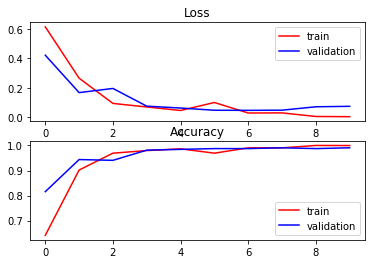

=== Evaluating model: A_A_inceptionv3-l2-final_10_adam.h5 ===

Accuracy: 0.998

Confusion Matrix
[[317   0]
 [  1 322]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       317
          1       1.00      1.00      1.00       323

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_inceptionv3-l2-best_10_adam.h5 ===

Accuracy: 0.986

Confusion Matrix
[[307   9]
 [  0 324]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.97      0.99       316
          1       0.97      1.00      0.99       324

avg / total       0.99      0.99      0.99       640



In [22]:
# Input: Elementwise Euclidean Distance
# In [32]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [33]:
def euclidean_distance(vecs):
    x, y = vecs
    return K.sqrt(K.sum(K.stack([K.square(x), -K.square(y)], axis=1), axis=1))

'''
stack  将秩 为 R 的张量列表堆叠成秩为 R + 1 的张量。
square 元素级的平方操作。
sum    计算张量在某一指定轴的和。
sqrt   元素级的平方根操作。
'''

def euclidean_distance_output_shape(shapes):
    xshape, yshape = shapes
    return xshape

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = euclidean_distance(vecs)
print(s.shape)

# In [34]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(euclidean_distance, 
                output_shape=euclidean_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [35]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [36]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [37]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "l2", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [39]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "l2", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 3] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: inceptionv3-l2-final.h5 ===

In [ ]:
# In [48]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "cat", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 0] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-cat-final.h5 ===


# Input: Elementwise Cosine Distance
# In [49]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [50]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [51]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [52]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [53]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "dot", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [54]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

Epoch 1/10
72/72 [==============================] - 3s 44ms/step - loss: 0.7965 - acc: 0.5668 - val_loss: 0.5289 - val_acc: 0.7688
Epoch 2/10
72/72 [==============================] - 1s 20ms/step - loss: 0.4306 - acc: 0.7999 - val_loss: 0.2926 - val_acc: 0.9062
Epoch 3/10
72/72 [==============================] - 1s 20ms/step - loss: 0.2032 - acc: 0.9236 - val_loss: 0.2457 - val_acc: 0.8969
Epoch 4/10
72/72 [==============================] - 1s 20ms/step - loss: 0.1458 - acc: 0.9488 - val_loss: 0.1218 - val_acc: 0.9656
Epoch 5/10
72/72 [==============================] - 1s 21ms/step - loss: 0.0832 - acc: 0.9740 - val_loss: 0.1672 - val_acc: 0.9469
Epoch 6/10
72/72 [==============================] - 1s 20ms/step - loss: 0.0740 - acc: 0.9740 - val_loss: 0.0930 - val_acc: 0.9625
Epoch 7/10
72/72 [==============================] - 1s 20ms/step - loss: 0.0473 - acc: 0.9857 - val_loss: 0.0958 - val_acc: 0.9688
Epoch 8/10
72/72 [==============================] - 1s 20ms/step - loss: 0.0410 - a

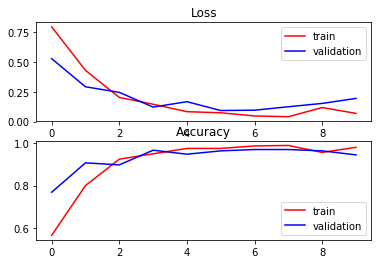

In [33]:
# ResNet 50 Vectors
# In [40]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-resnet-vectors.tsv")
# In [41]:
vec_dict = load_vectors(VECTOR_FILE)
# Input: Concatenate vectors
# In [42]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [43]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Concatenate(axis=-1)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [44]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [45]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [46]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "cat", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [47]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

=== Evaluating model: A_A_resnet50-dot-final_10.h5 ===

Accuracy: 0.953

Confusion Matrix
[[279  30]
 [  0 331]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.90      0.95       309
          1       0.92      1.00      0.96       331

avg / total       0.96      0.95      0.95       640

=== Evaluating model: A_A_resnet50-cat-best_10.h5 ===

Accuracy: 0.964

Confusion Matrix
[[292  21]
 [  2 325]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.93      0.96       313
          1       0.94      0.99      0.97       327

avg / total       0.97      0.96      0.96       640

Epoch 1/10
72/72 [==============================] - 3s 39ms/step - loss: 0.4064 - acc: 0.8138 - val_loss: 0.1506 - val_acc: 0.9531
Epoch 2/10
72/72 [==============================] - 1s 14ms/step - loss: 0.0696 - acc: 0.9852 - val_loss: 0.0622 - val_acc: 0.9938
Epoch 3/10
72/72 [===================

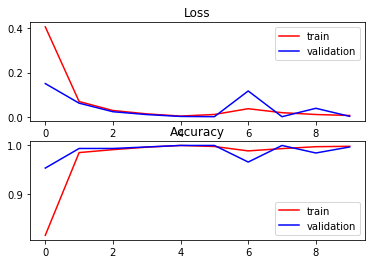

=== Evaluating model: A_A_resnet50-l1-final_10.h5 ===

Accuracy: 1.000

Confusion Matrix
[[310   0]
 [  0 330]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       310
          1       1.00      1.00      1.00       330

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_resnet50-l1-best_10.h5 ===

Accuracy: 1.000

Confusion Matrix
[[309   0]
 [  0 331]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       309
          1       1.00      1.00      1.00       331

avg / total       1.00      1.00      1.00       640

Epoch 1/10
72/72 [==============================] - 3s 41ms/step - loss: 0.5162 - acc: 0.7201 - val_loss: 0.2774 - val_acc: 0.9094
Epoch 2/10
72/72 [==============================] - 1s 14ms/step - loss: 0.1990 - acc: 0.9345 - val_loss: 0.2373 - val_acc: 0.9375
Epoch 3/10
72/72 [=====================

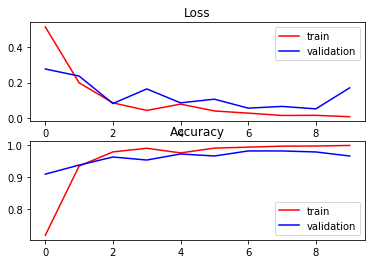

=== Evaluating model: A_A_resnet50-l2-final_10.h5 ===

Accuracy: 0.964

Confusion Matrix
[[287  23]
 [  0 330]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.93      0.96       310
          1       0.93      1.00      0.97       330

avg / total       0.97      0.96      0.96       640

=== Evaluating model: A_A_resnet50-l2-best_10.h5 ===

Accuracy: 0.994

Confusion Matrix
[[306   2]
 [  2 330]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       308
          1       0.99      0.99      0.99       332

avg / total       0.99      0.99      0.99       640



In [34]:
# In [55]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "dot", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 1] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-dot-final.h5 ===

# Input: Elementwise Absolute Difference
# In [56]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [57]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(absdiff, output_shape=absdiff_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [58]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [59]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [60]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "l1", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [62]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "l1", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 2] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-l1-final.h5 ===


# Input: Elementwise Euclidean Distance
# In [63]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [64]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(euclidean_distance, 
                output_shape=euclidean_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [65]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [66]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [67]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "l2", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [68]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [69]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "l2", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 3] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-l2-final.h5 ===

Text(0.5,1,'Neural Network Classifiers with Image Vectors')

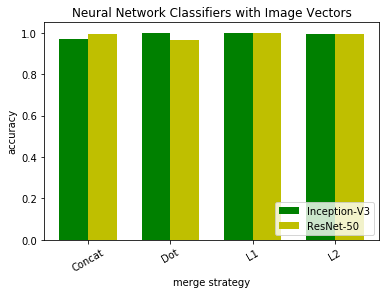

In [35]:
# In [71]:
width=0.35
plt.bar(np.arange(scores.shape[1]), scores[0], width, color="g", label="Inception-V3")
plt.bar(np.arange(scores.shape[1])+width, scores[1], width, color="y", label="ResNet-50")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xlabel("merge strategy")
plt.xticks(np.arange(scores.shape[1])+0.5*width, ["Concat", "Dot", "L1", "L2"],
          rotation=30)
plt.title("Neural Network Classifiers with Image Vectors")
# Out[71]:
# <matplotlib.text.Text at 0x7fe1aa6d1050>

# In [ ]: